# VGAEを活用したデータ生成
- VGAEを活用して信用スコアに有効性があることを検証する

In [681]:
# GPU&PyTorchの動作確認
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Jul  3 2025, 17:03:59) [GCC 11.4.0]
PyTorch：2.7.1+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得
### neo4jからグラフデータの取得

In [682]:
# neo4jからネットワークデータを取得

from neo4j import GraphDatabase
import pandas as pd

# neo4j serverに接続するdriverの設定
driver = GraphDatabase.driver('neo4j://graph-db:7687')

# relationがあるデータを取得する
def fetch_transaction(tx, contract_address = "all"):
    query = "MATCH p=()-[r:TRANSFER]->() RETURN p"
    if contract_address != "all" or contract_address == "":
        query = "MATCH p=()-[r:TRANSFER {contractAddress: $address}]->() RETURN p"
    else:
        query = """
        MATCH p=()-[r:TRANSFER]->()
        WHERE r.contractAddress <> "0x50cA110B20FebEF46647c9bd68cAF848c56d9d03"
        RETURN p
        """

    transactions = tx.run(query, address=contract_address)
    return list(transactions)

# contract_address = "0x6dBccC65133635D27AE56B7E3586b6e810d92082"
contract_address = "all"  # 全てのトランザクションを取得する場合は "all" を指定
transactions = list()
relations = list()

# neo4jに接続してトランザクションを実行
with driver.session() as session:
    transactions = session.execute_read(fetch_transaction, contract_address)

# トランザクションの結果をリストに保存
for transaction in transactions:
    path = transaction["p"]
    start_node = path.start_node
    end_node = path.end_node
    gasPrice = transaction["p"].relationships[0]["gasPrice"]
    gasUsed = transaction["p"].relationships[0]["gasUsed"]
    contract_address = transaction["p"].relationships[0]["contractAddress"]

    relations.append({
        "from": start_node["address"], 
        "to": end_node["address"],
        "gasPrice": gasPrice,
        "gasUsed": gasUsed,
        "contractAddress": contract_address
    })

# 結果をpandasで保存
df_relation = pd.DataFrame(relations)
display(df_relation.head())

,from,to,gasPrice,gasUsed,contractAddress
0,0x90e3d7C40F72F1fB3189AFC86e92c67dAfabB323,0x0c7415dDBAFabc13206631DBf1B83f6eBD4Ee144,51.193516,0.000168,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D
1,0x0c7415dDBAFabc13206631DBf1B83f6eBD4Ee144,0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,35.980158,0.000139,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D
2,0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,24.822893,0.000086,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D
3,0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0xA38dd89354f31235917C43632692A1f10FAfc8b2,20.640621,0.000098,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D
4,0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,20.725437,0.000086,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D


In [683]:
# コントラクトごとの統計情報を集計
contract_summary = df_relation.groupby('contractAddress').agg({
    'from': 'count',  # リレーション数
    'to': lambda x: len(pd.concat([df_relation[df_relation['contractAddress'] == x.name]['from'], 
                                   df_relation[df_relation['contractAddress'] == x.name]['to']]).unique())
}).reset_index()
contract_stats = []
for contract_addr in df_relation['contractAddress'].unique():
    # 該当コントラクトのデータを抽出
    contract_data = df_relation[df_relation['contractAddress'] == contract_addr]
    
    # ユニークアドレス数（fromとtoの両方を含む）
    unique_addresses = pd.concat([contract_data['from'], contract_data['to']]).unique()
    address_count = len(unique_addresses)
    
    # リレーション数
    relation_count = len(contract_data)
    
    contract_stats.append({
        'コントラクトアドレス': contract_addr,
        'ユーザー数': address_count,
        '取引数': relation_count
    })
contract_summary_table = pd.DataFrame(contract_stats)
contract_summary_table = contract_summary_table.sort_values('取引数', ascending=False)

display(contract_summary_table)

,コントラクトアドレス,ユーザー数,取引数
2,0x6dBccC65133635D27AE56B7E3586b6e810d92082,33,922
0,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D,108,435
3,0x0D48C738959d5a16108b475a8d0e98d9620BdEB8,34,215
1,0x76B50696B8EFFCA6Ee6Da7F6471110F334536321,295,209


### 取得したデータの可視化

生成されたグラフ: ノード数=469, エッジ数=496


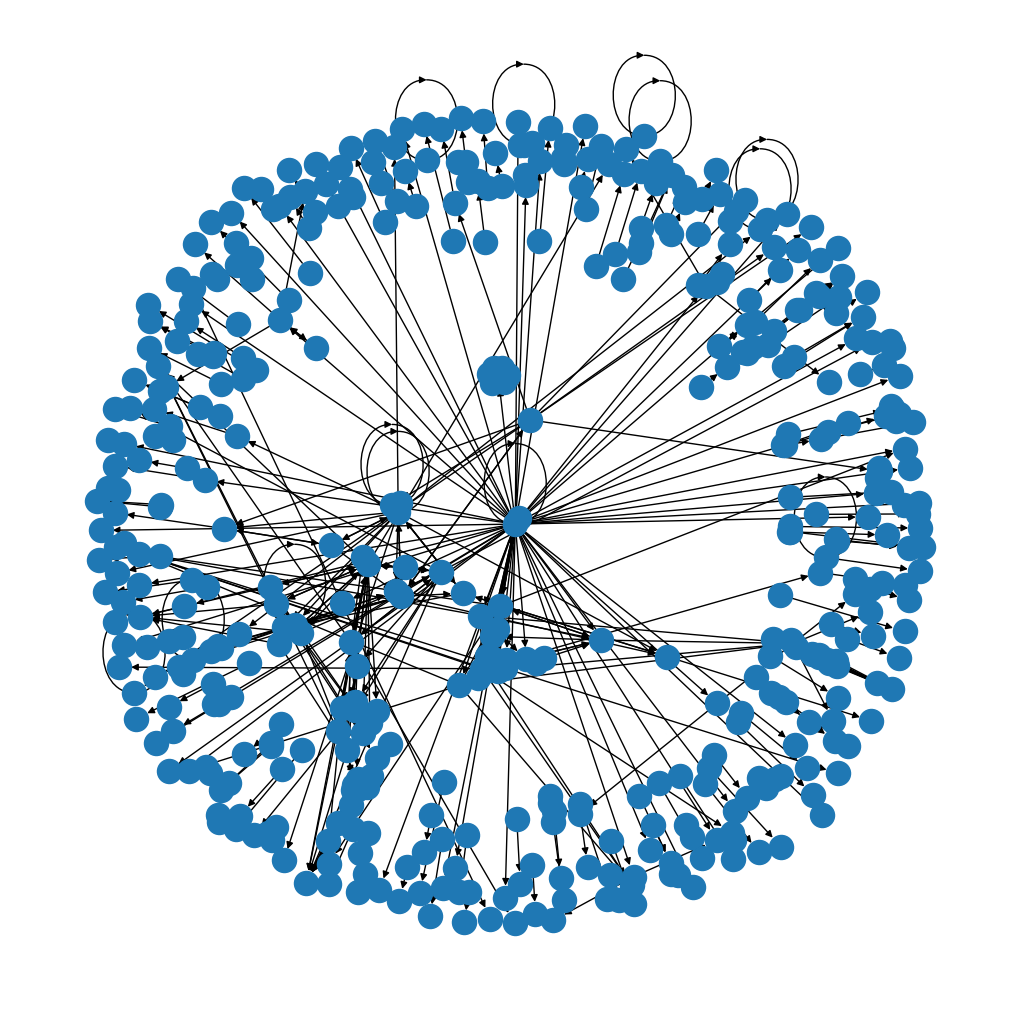

In [ ]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

G = nx.DiGraph()
for index, transaction in df_relation.iterrows():
    G.add_edge(transaction["from"], transaction["to"])
print(f"生成されたグラフ: ノード数={G.number_of_nodes()}, エッジ数={G.number_of_edges()}")

# グラフの表示
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False)
plt.savefig("2025/jsme_data/train_graph.png")
plt.show()

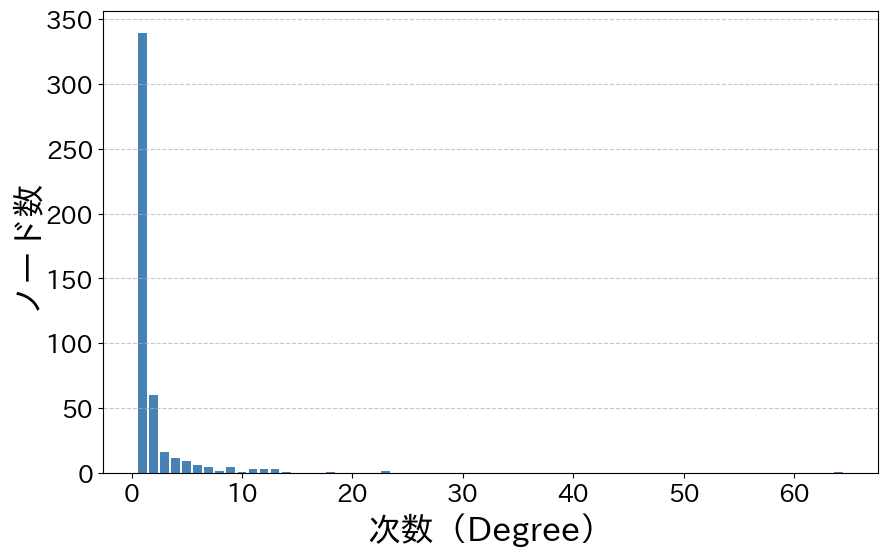

平均次数: 2.12
最大次数: 64
最小次数: 1
次数0のノード数: 0


In [ ]:
# グラフの次数分布を計算して表示
degrees = [deg for node, deg in G.degree()]
degree_counts = {}

# 次数ごとの頂点数をカウント
for d in degrees:
    if d in degree_counts:
        degree_counts[d] += 1
    else:
        degree_counts[d] = 1

# 次数分布をプロット
plt.figure(figsize=(10, 6))
plt.bar(degree_counts.keys(), degree_counts.values(), color='steelblue')
plt.xlabel('次数（Degree）', fontsize=24)
plt.ylabel('ノード数', fontsize=24)
# plt.title('グラフの次数分布')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(labelsize=18)
plt.savefig(f"2025/jsme_data/train_graph_degree_distribution.png")
plt.show()

# 統計情報も表示
print(f"平均次数: {sum(degrees) / len(degrees):.2f}")
print(f"最大次数: {max(degrees)}")
print(f"最小次数: {min(degrees)}")
print(f"次数0のノード数: {degrees.count(0)}")

In [686]:
df_centrality = pd.DataFrame(
    index=list(G.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 次数中心性
degree = nx.in_degree_centrality(G)
df_centrality["degree"] = pd.Series(degree)
# 媒介中心性
betweenness = nx.betweenness_centrality(G)
df_centrality["betweenness"] = pd.Series(betweenness)
# PageRank
pagerank = nx.pagerank(G, max_iter=1000)
df_centrality["pagerank"] = pd.Series(pagerank)

display(df_centrality.head(20))

,degree,betweenness,pagerank
0x90e3d7C40F72F1fB3189AFC86e92c67dAfabB323,0.002137,0.000055,0.002974
0x0c7415dDBAFabc13206631DBf1B83f6eBD4Ee144,0.002137,0.000027,0.003644
0x7C6FC3Cf6a87D0A8d7F37E06A5ea7DFBC1a18739,0.006410,0.000151,0.004371
0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,0.006410,0.003995,0.002463
0xA38dd89354f31235917C43632692A1f10FAfc8b2,0.014957,0.003574,0.004330
0x5d879BC99b0f94260Aa3A2049A002f4652f69EF3,0.002137,0.000000,0.001451
0x5e33CF3a0aE32A349F537E596cCd89e4C7385B0b,0.014957,0.000133,0.003432
0x1231123123123123123123123123123123123123,0.004274,0.000000,0.001734
0x1234567891231211231231231231231231231231,0.002137,0.000000,0.001699
0x809aD7b400325dB25702563aCC7E7D29212739F5,0.002137,0.000000,0.001150


In [687]:
# networkxのグラフをtorch_geometricのDataに変換
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid 
from torch_geometric.utils import (
    train_test_split_edges,
)

# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
unique_nodes = pd.concat([df_relation['from'], df_relation['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}

# # pytorch_geometricに変換
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_relation.iterrows()],
    dtype=torch.long
).t().contiguous()

# ノードの特徴量をdf_centralityから取得
x = torch.tensor(df_centrality.loc[unique_nodes].values, dtype=torch.float)
# x = torch.randn((len(unique_nodes), 8))  # ノードの特徴量をランダムに初期化
data = Data(x=x, edge_index=edge_index)

# エッジをトレーニング、検証、テストセットに分割
data = train_test_split_edges(data)

# print("PyTorch Geometric Data:", data)
print(data.x)
print("Edge Index:", data.train_pos_edge_index)

tensor([[2.1368e-03, 5.4906e-05, 2.9738e-03],
        [2.1368e-03, 2.7453e-05, 3.6442e-03],
        [6.4103e-03, 3.9952e-03, 2.4628e-03],
        ...,
        [2.1368e-03, 0.0000e+00, 2.3225e-03],
        [2.1368e-03, 0.0000e+00, 1.2682e-03],
        [2.1368e-03, 0.0000e+00, 4.5274e-03]])
Edge Index: tensor([[  0,   1,   1,  ..., 466, 467, 468],
        [  1,   0,   3,  ..., 263, 249, 266]])


/app/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## VGANを活用したグラフ生成
### モデルの定義

In [688]:
from torch_geometric.nn import GCNConv, VGAE

# Encoderの定義
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

in_channels = data.x.size(-1) # 入力される特徴量の次元
out_channels = 3 # 出力される特徴量の次元
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")
model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels)) # エンコーダとデコーダーを合わせてモデルのインスタンス化

入力特徴量の次元: 3, 出力特徴量の次元: 3


### モデルの学習
- パラメータの調整にはAdam
- 目的関数
    - KLダイバージェンス
    - 再構成誤差

In [689]:
# モデルの学習
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # 利用するデバイスを選択
data = data.to(device)  # データをGPUに転送
best_loss = float('inf') # 最良モデルの追跡用変数

data_dir = "data/model"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    recon_loss = model.recon_loss(z, data.train_pos_edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 301):
    loss = train()
    # 現在のエポックでのlossが最良の場合、モデルを保存
    if loss < best_loss:
        best_loss = loss
        # モデルの保存
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join("data/model", 'best_model.pt'))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 50, Loss: 1.4656658172607422
Epoch 100, Loss: 1.3791565895080566
Epoch 150, Loss: 1.3519612550735474
Epoch 200, Loss: 1.3458220958709717
Epoch 250, Loss: 1.3334612846374512
Epoch 300, Loss: 1.3373150825500488


### モデルの評価とネットワークの生成

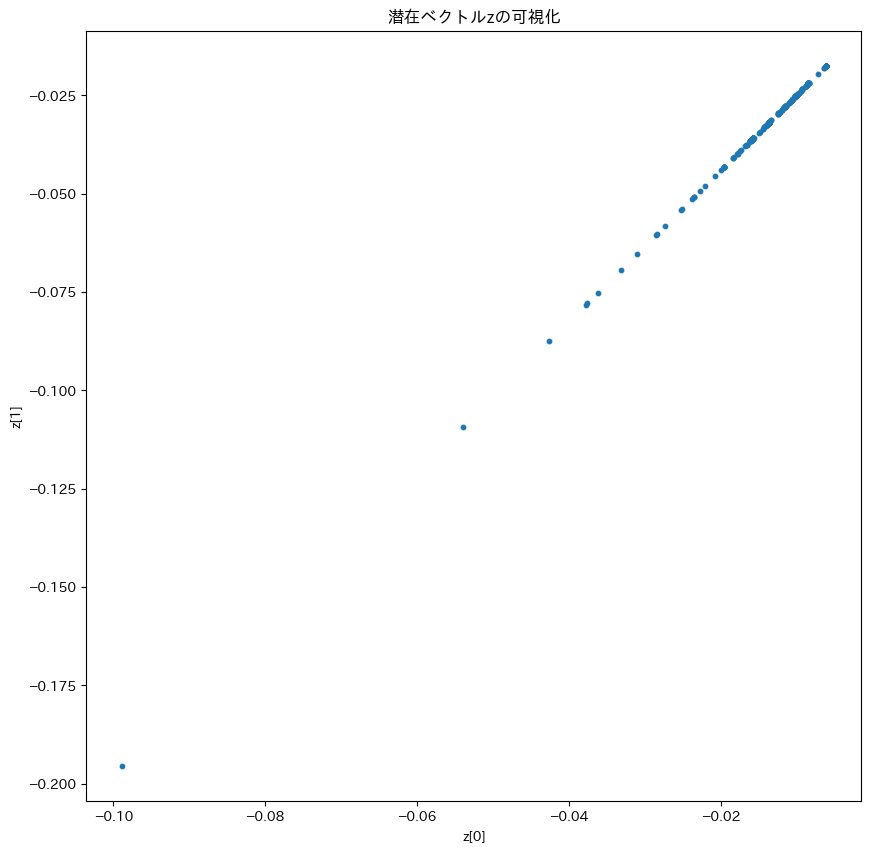

In [690]:
# グラフを生成する関数
def generate_graph(model, data):
    model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels))
    checkpoint = torch.load(os.path.join("data/model", 'best_model.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)  # モデルをGPUに転送
    data = data.to(device)  # データをGPUに転送
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)  # エンコーダを使用して潜在ベクトルzを生成
        # 潜在ベクトルzの可視化
        plt.figure(figsize=(10, 10))
        plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
        plt.title("潜在ベクトルzの可視化")
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()

        # 潜在ベクトルzをデコードして隣接行列を生成
        adj = z @ z.t()  # xとzの内積を計算して隣接行列を生成
        # adj = torch.matmul(z, z.t())  # 潜在ベクトルzの外積を計算して隣接行列を生成
        adj = torch.sigmoid(adj)  # Sigmoid関数を適用して隣接行列を確率に変換
        tau = 0.8
        adj_matrix = (adj > tau).nonzero(as_tuple=False).t()

        return adj_matrix

# 取引0のグラフデータを作成
sample = generate_graph(model, data)

生成されたグラフ: ノード数=469, エッジ数=851


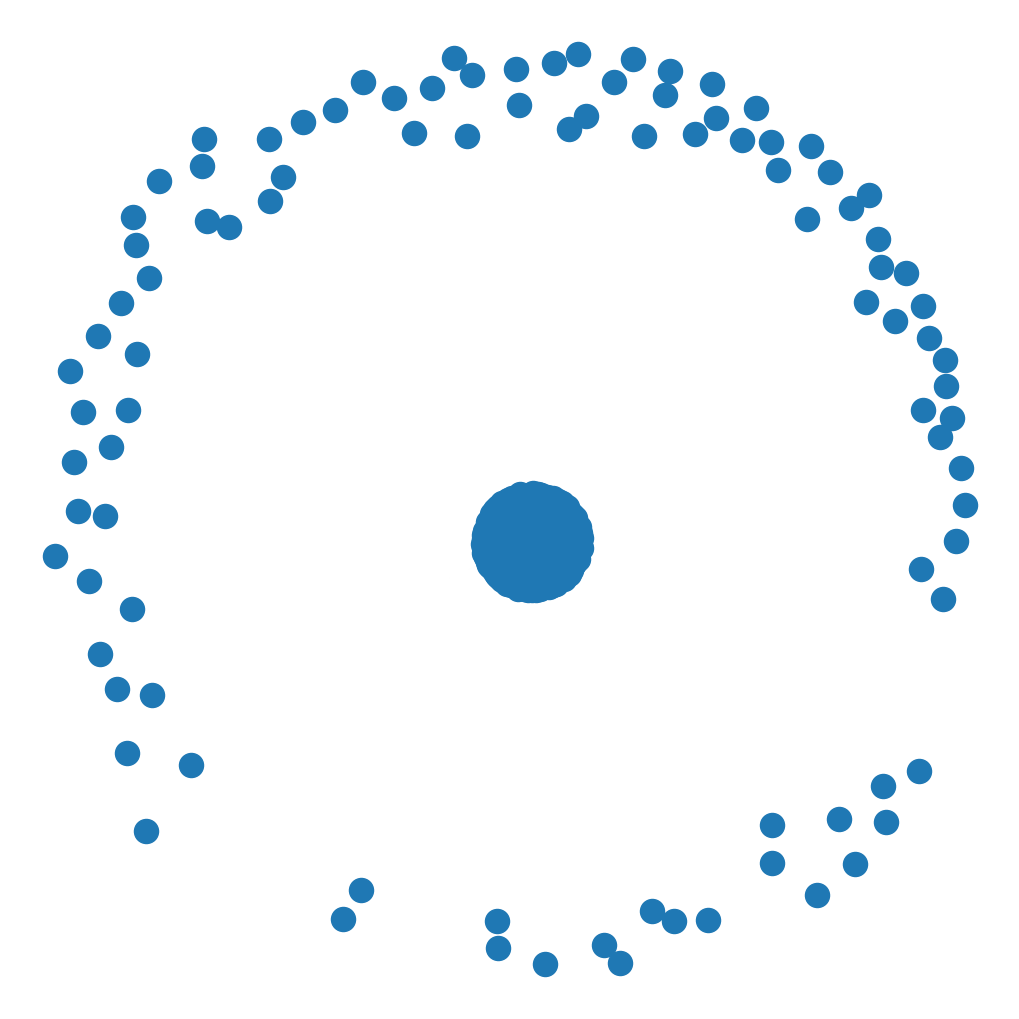

In [ ]:
g_gen = nx.DiGraph()  # 有向グラフの作成
g_gen.add_nodes_from(range(data.num_nodes))  # ノードを追加
g_gen.add_edges_from(sample.t().cpu().numpy())  # エッジを追加
print(f"生成されたグラフ: ノード数={g_gen.number_of_nodes()}, エッジ数={g_gen.number_of_edges()}")

plt.figure(figsize=(10, 10))
nx.draw(g_gen, with_labels=False)
# plt.title("生成されたグラフ")
plt.savefig(f"2025/jsme_data/generated_graph.png", format="png")
plt.show()

削除後のグラフ: ノード数=372, エッジ数=844


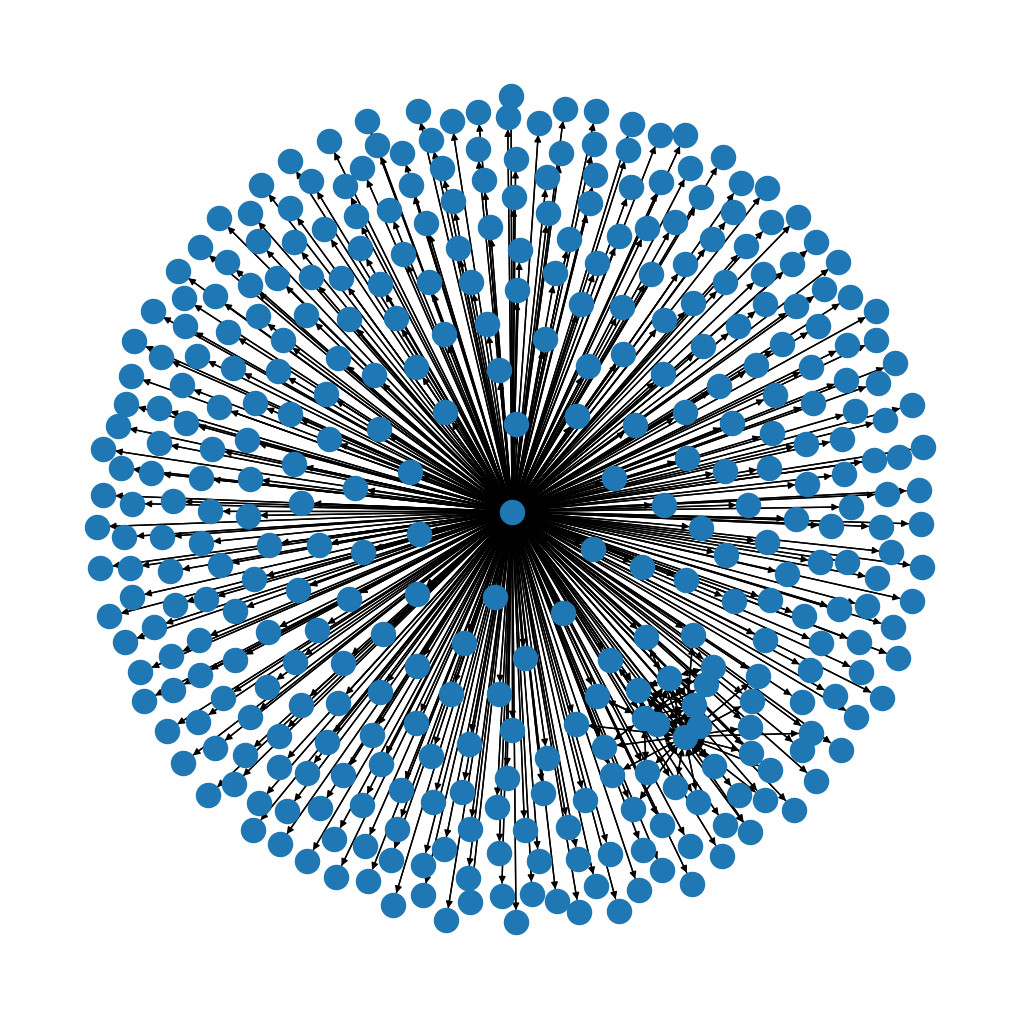

In [ ]:
# g_genから次数が0のノードを削除
zero_degree_nodes = [node for node, degree in dict(g_gen.degree()).items() if degree == 0]
g_gen_removed = g_gen.copy()
g_gen_removed.remove_nodes_from(zero_degree_nodes)

# 自己ループを削除
g_gen_removed.remove_edges_from(nx.selfloop_edges(g_gen_removed))

print(f"削除後のグラフ: ノード数={g_gen_removed.number_of_nodes()}, エッジ数={g_gen_removed.number_of_edges()}")

plt.figure(figsize=(10, 10))
nx.draw(g_gen_removed, with_labels=False)
# plt.title("次数0のノードを削除したグラフ")
plt.savefig(f"2025/jsme_data/generated_removed_zero_degree_nodes_graph.png", format="png")
plt.show()

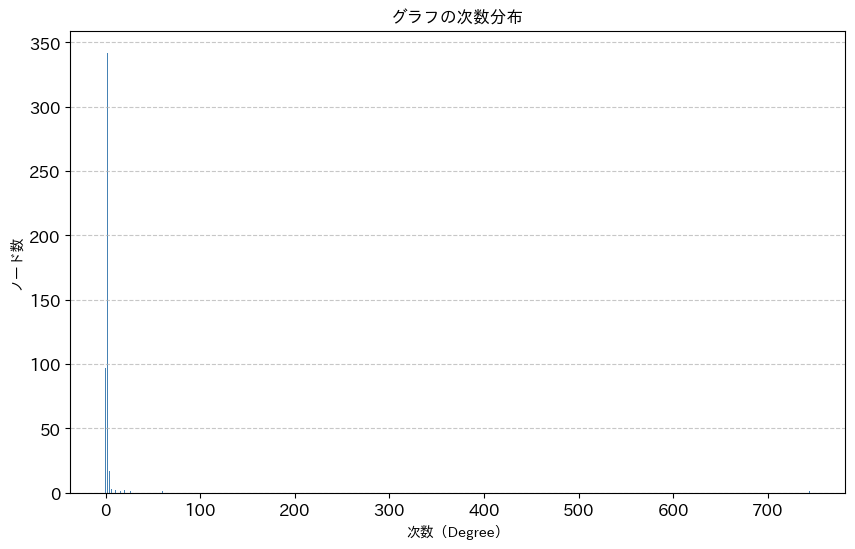

平均次数: 3.63
最大次数: 744
最小次数: 0
次数0のノード数: 97


In [693]:
# グラフの次数分布を計算して表示
degrees = [deg for node, deg in g_gen.degree()]
degree_counts = {}

# 次数ごとの頂点数をカウント
for d in degrees:
    if d in degree_counts:
        degree_counts[d] += 1
    else:
        degree_counts[d] = 1

# 次数分布をプロット
plt.figure(figsize=(10, 6))
plt.bar(degree_counts.keys(), degree_counts.values(), color='steelblue')
plt.xlabel('次数（Degree）')
plt.ylabel('ノード数')
plt.title('グラフの次数分布')
plt.tick_params(labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 統計情報も表示
print(f"平均次数: {sum(degrees) / len(degrees):.2f}")
print(f"最大次数: {max(degrees)}")
print(f"最小次数: {min(degrees)}")
print(f"次数0のノード数: {degrees.count(0)}")

In [694]:
# g_genの次数中心性・媒介中心性・PageRankを計算
centrality_df = pd.DataFrame(
    index=list(g_gen.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 次数中心性
degree_centrality = nx.in_degree_centrality(g_gen)
centrality_df["degree"] = pd.Series(degree_centrality)
# 媒介中心性
betweenness_centrality = nx.betweenness_centrality(g_gen)
centrality_df["betweenness"] = pd.Series(betweenness_centrality)
# PageRank
pagerank_centrality = nx.pagerank(g_gen, max_iter=1000)
centrality_df["pagerank"] = pd.Series(pagerank_centrality)

display(centrality_df.head(20))

# 外れ値の除去
# 閾値を超える次数中心性を持つ行の削除
centrality_df_out = centrality_df.copy()
centrality_df_out = centrality_df_out[centrality_df_out["degree"] < 0.4]
centrality_df_out = centrality_df_out[centrality_df_out["betweenness"] < 0.4]
centrality_df_out = centrality_df_out[centrality_df_out["pagerank"] < 0.4]

,degree,betweenness,pagerank
0,0.002137,0.000000,0.001313
1,0.002137,0.000000,0.001313
2,0.794872,0.625927,0.404889
3,0.002137,0.000000,0.001313
4,0.010684,0.000000,0.003692
5,0.004274,0.000000,0.001967
6,0.002137,0.000000,0.001313
7,0.002137,0.000000,0.001313
8,0.002137,0.000000,0.001313
9,0.002137,0.000000,0.001313


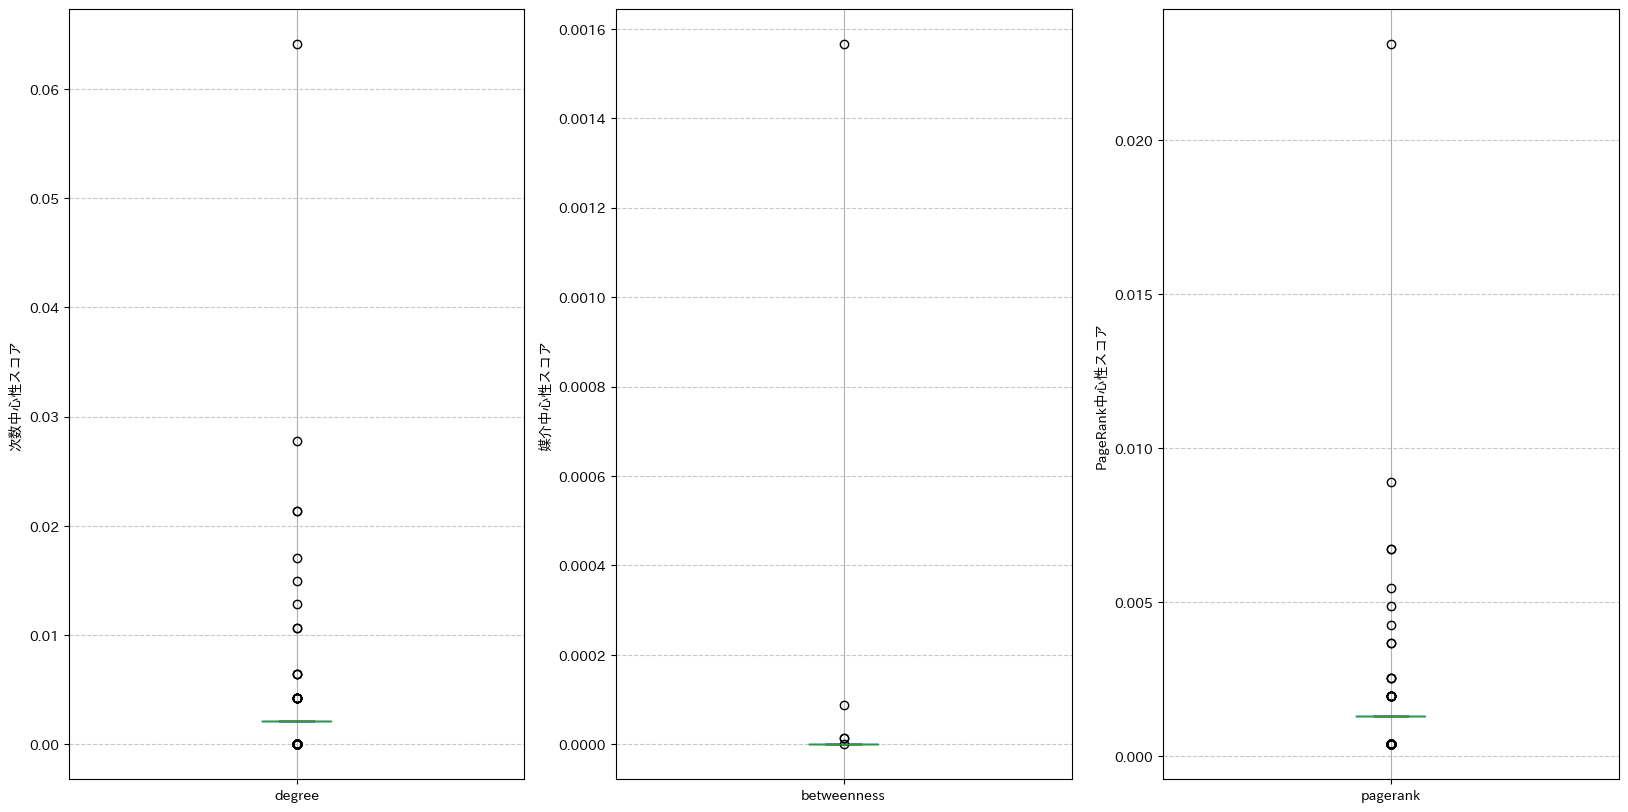

In [ ]:
# 箱ひげ図でcentrality_df_outを可視化(3つとも別の図)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
centrality_df_out.boxplot(column=["degree"])
# plt.title("生成グラフの次数中心性の箱ひげ図")
plt.ylabel("次数中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
centrality_df_out.boxplot(column=["betweenness"])
# plt.title("生成グラフの媒介中心性の箱ひげ図")
plt.ylabel("媒介中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
centrality_df_out.boxplot(column=["pagerank"])
# plt.title("生成グラフのPageRankの箱ひげ図")
plt.ylabel("PageRank中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f"2025/jsme_data/boxplot_centrality_original.png")
plt.show()

## VGAEの有効性評価
- ありがトークンの取引履歴を利用してネットワーク生成の効果を検証
- 取引が少ないユーザーに対して新たなつながりの推定する

### 実際の取引ネットワーク

In [696]:
contract_address = "0x50cA110B20FebEF46647c9bd68cAF848c56d9d03"
with driver.session() as session:
    new_transactions = session.execute_read(fetch_transaction, contract_address)

new_transactions = list(new_transactions)
new_relations = list()

# トランザクションの結果をリストに保存
for transaction in new_transactions:
    path = transaction["p"]
    start_node = path.start_node
    end_node = path.end_node
    gasPrice = transaction["p"].relationships[0]["gasPrice"]
    gasUsed = transaction["p"].relationships[0]["gasUsed"]

    new_relations.append({
        "from": start_node["address"], 
        "to": end_node["address"],
        "gasPrice": gasPrice,
        "gasUsed": gasUsed
    })

# 結果をpandasで保存
df_new_relation = pd.DataFrame(new_relations)

# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
new_unique_nodes = pd.concat([df_new_relation['from'], df_new_relation['to']]).unique()
new_node_to_index = {node: idx for idx, node in enumerate(new_unique_nodes)}

# pytorch_geometricに変換
new_edge_index = torch.tensor(
    [[new_node_to_index[row['from']], new_node_to_index[row['to']]] for _, row in df_new_relation.iterrows()],
    dtype=torch.long
).t().contiguous()

new_G = nx.DiGraph()
for index, transaction in df_new_relation.iterrows():
    new_G.add_edge(transaction["from"], transaction["to"])

df_new_centrality = pd.DataFrame(
    index=list(new_G.nodes),
    columns=["degree", "betweenness", "pagerank", "prediction_degree", "prediction_betweenness", "prediction_pagerank"]
)

# 次数中心性
degree = nx.in_degree_centrality(new_G)
df_new_centrality["degree"] = pd.Series(degree)
# 媒介中心性
betweenness = nx.betweenness_centrality(new_G)
df_new_centrality["betweenness"] = pd.Series(betweenness)
# PageRank
pagerank = nx.pagerank(new_G, max_iter=1000)
df_new_centrality["pagerank"] = pd.Series(pagerank)
# 予測値を追加
df_new_centrality["prediction_degree"] = 0.0
df_new_centrality["prediction_betweenness"] = 0.0
df_new_centrality["prediction_pagerank"] = 0.0

# ノードの特徴量をdf_new_centralityから取得
new_x = torch.tensor(df_new_centrality[["degree", "betweenness", "pagerank"]].loc[new_unique_nodes].values, dtype=torch.float)
new_data = Data(x=new_x, edge_index=new_edge_index)

display(df_new_centrality.head(20))
print("新しいデータのノード数:", new_data.num_nodes)
print("新しいデータのエッジ数:", new_data.num_edges)


,degree,betweenness,pagerank,prediction_degree,prediction_betweenness,prediction_pagerank
0x570023cf51Ed0066F918017CD64356E50AD76855,0.333333,0.027778,0.167851,0.0,0.0,0.0
0xfA8e4A9835eF1b247B24dD03D3aB33cc7D2E583b,0.444444,0.055556,0.181272,0.0,0.0,0.0
0x98A37E304758fc0f77d0A7DeA3C78604efc78aD6,0.222222,0.000000,0.163377,0.0,0.0,0.0
0x3799B36Fef5E2E7f392D21668033dA96C0913838,0.222222,0.013889,0.122975,0.0,0.0,0.0
0x5B37440170e1b2569b87E410A01feE3B29aB8034,0.111111,0.000000,0.119525,0.0,0.0,0.0
0xdb02D6C4D4d2A6D1250427A560ACe2614F35f9b4,0.111111,0.000000,0.100000,0.0,0.0,0.0
0x07033d49613a4C1Fd3B080cd11Ad22C39c526Dc2,0.111111,0.000000,0.100000,0.0,0.0,0.0
0xB73336f77731142D64C347c588bCF1BbEb3F4107,0.000000,0.000000,0.015000,0.0,0.0,0.0
0xc787d11969d71249C6D09382366040DA3154C19f,0.000000,0.000000,0.015000,0.0,0.0,0.0
0x39C2d0A85837f73B821D324Ed64623447D897f0E,0.000000,0.000000,0.015000,0.0,0.0,0.0


新しいデータのノード数: 10
新しいデータのエッジ数: 20


ありがトークングラフ: ノード数=10, エッジ数=14


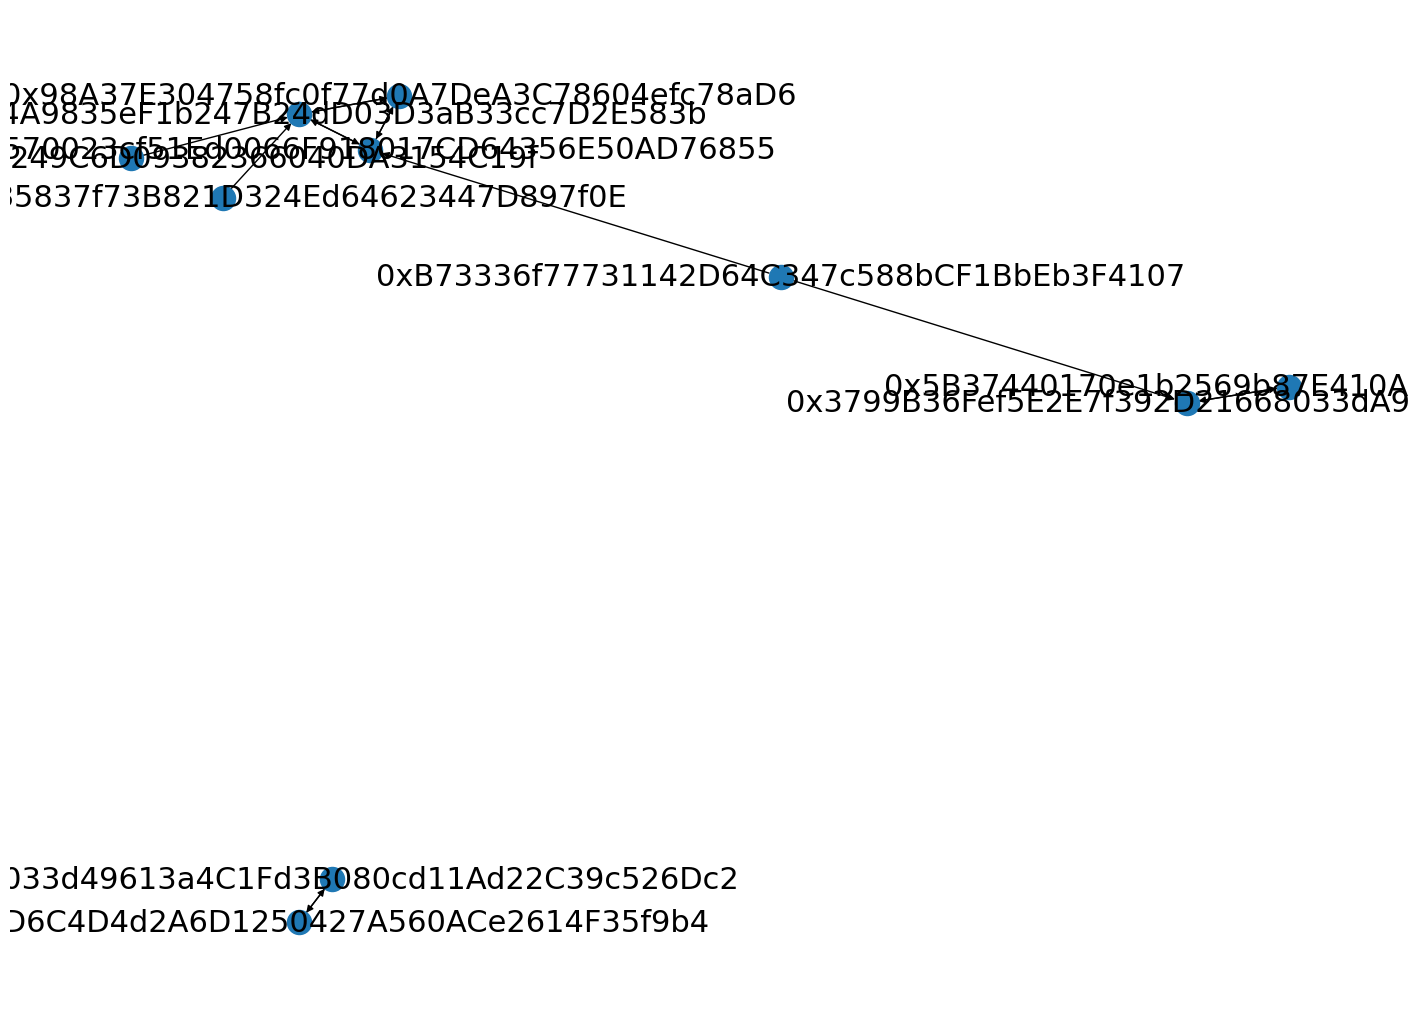

In [ ]:
print(f"ありがトークングラフ: ノード数={new_G.number_of_nodes()}, エッジ数={new_G.number_of_edges()}")
plt.figure(figsize=(14, 10))
nx.draw(new_G, with_labels=True, font_size=22)
plt.savefig(f"2025/jsme_data/new_graph.png")
plt.show()

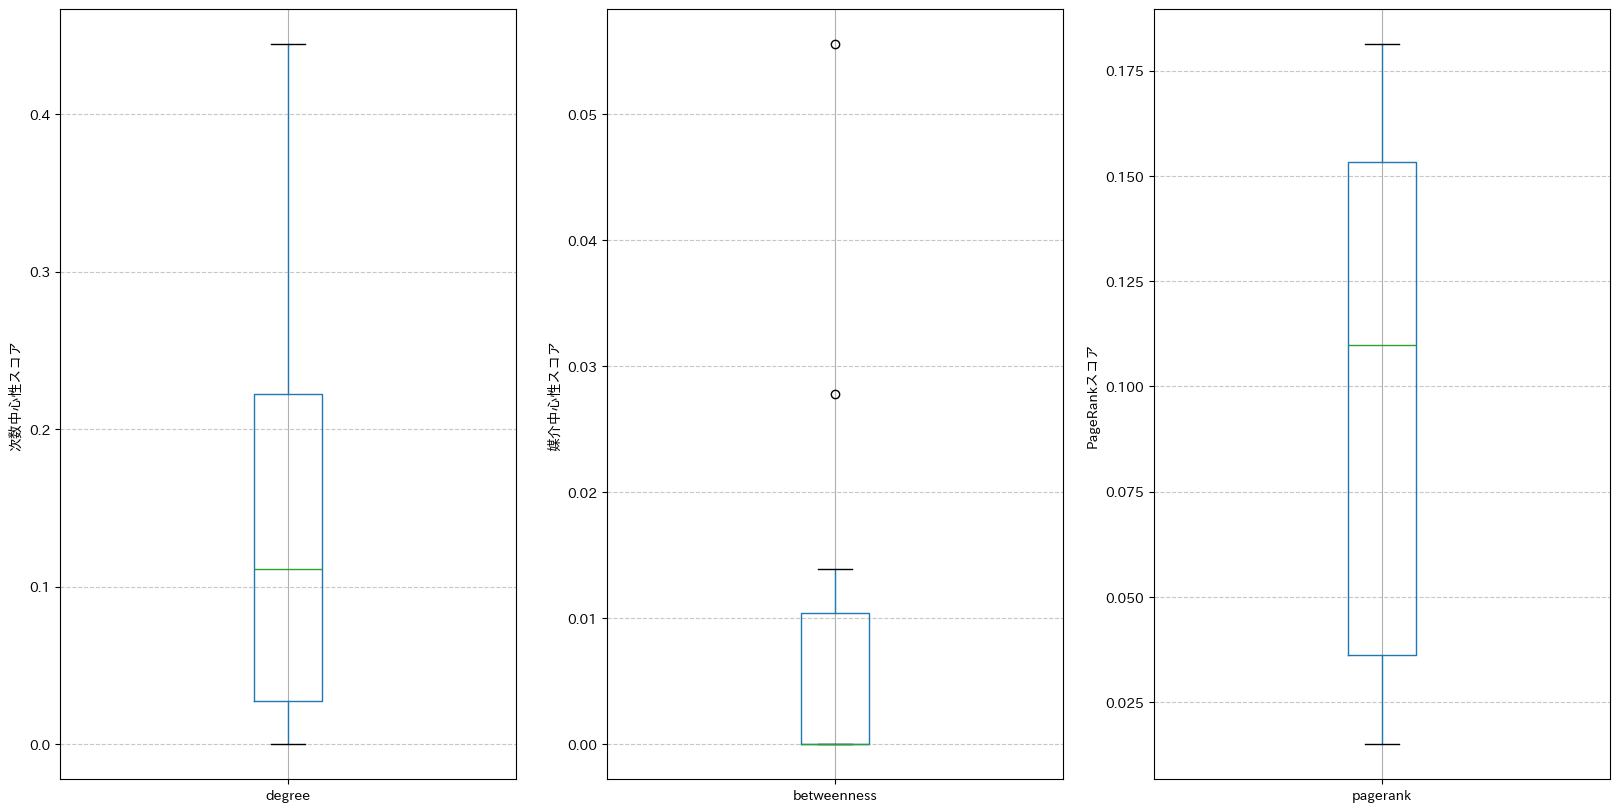

In [ ]:
# 箱ひげ図でcentrality_df_outを可視化(3つとも別の図)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
df_new_centrality.boxplot(column=["degree"])
# plt.title("生成グラフの次数中心性の箱ひげ図")
plt.ylabel("次数中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
df_new_centrality.boxplot(column=["betweenness"])
# plt.title("生成グラフの媒介中心性の箱ひげ図")
plt.ylabel("媒介中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
df_new_centrality.boxplot(column=["pagerank"])
# plt.title("生成グラフのPageRankの箱ひげ図")
plt.ylabel("PageRankスコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f"2025/jsme_data/boxplot_centrality_generated.png")
plt.show()

### ネットワーク生成による新たなつながりの推定

In [699]:
# new_data.xのノード特徴量を使ってVGAEモデルで新しいグラフを生成
def generate_graph_from_new_data(model, new_data, tau=0.9):
    model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels))
    checkpoint = torch.load(os.path.join("data/model", 'best_model.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    new_data = new_data.to(device)
    model.eval()
    with torch.no_grad():
        z = model.encode(new_data.x, new_data.edge_index)  # エンコーダを使用して潜在ベクトルzを生成
        adj = torch.sigmoid(z @ z.t())
        tau = tau
        adj_matrix = (adj > tau).nonzero(as_tuple=False).t()
        return adj_matrix

新しい生成グラフ: ノード数=10, エッジ数=60


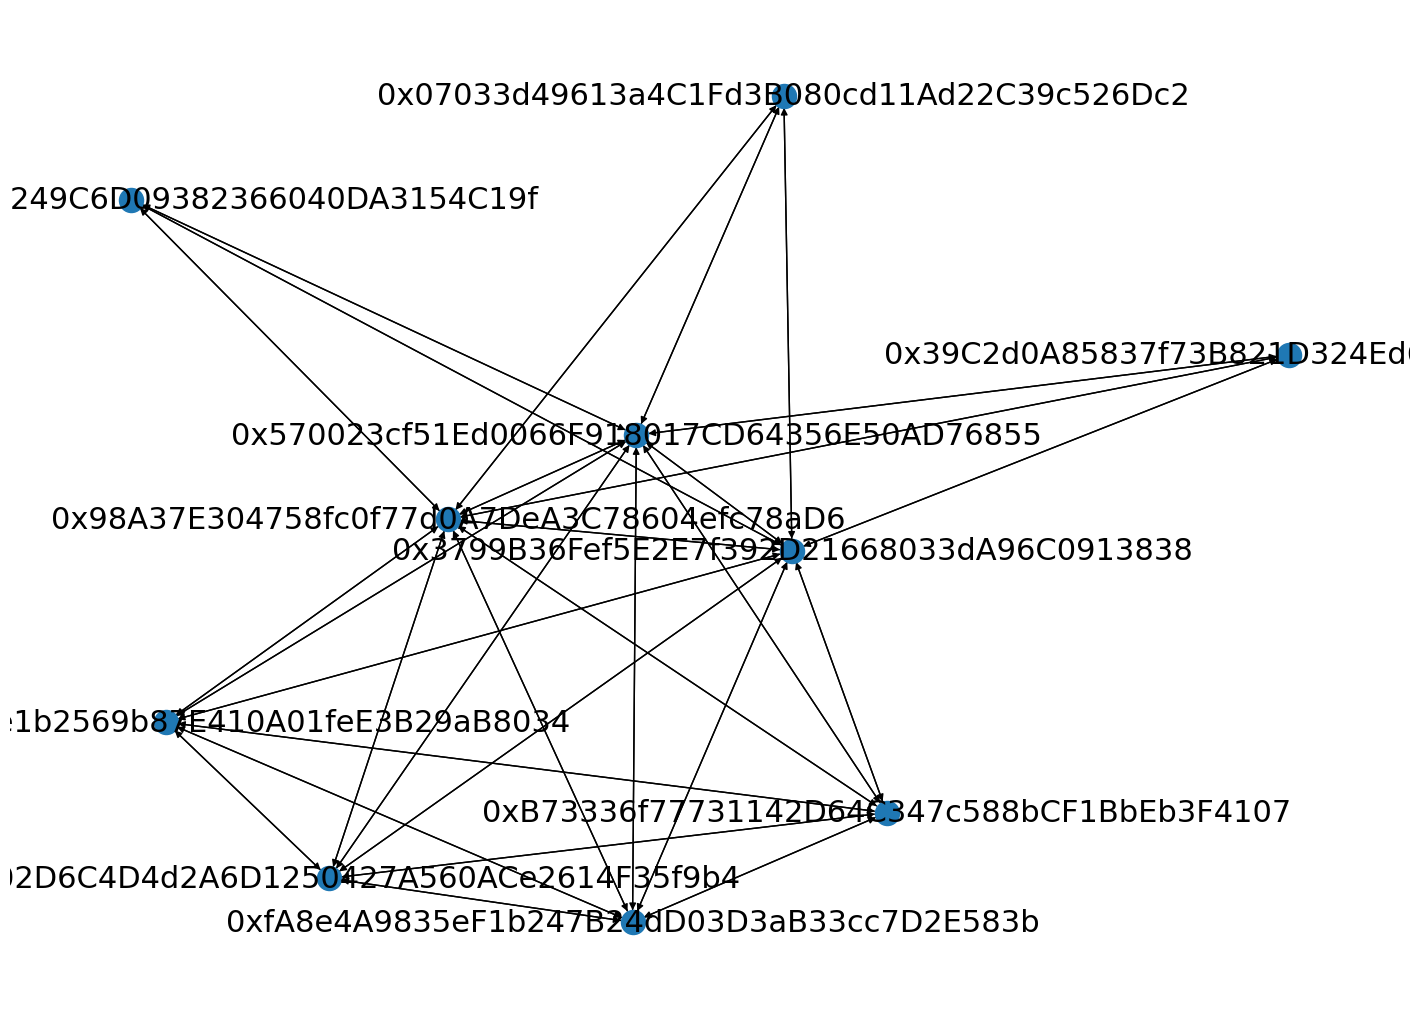

In [ ]:
# 生成
new_sample = generate_graph_from_new_data(model, new_data=new_data, tau=0.7)

# グラフ構築
new_g_gen = nx.DiGraph()
new_g_gen.add_nodes_from(range(new_data.num_nodes))
new_g_gen.add_edges_from(new_sample.t().cpu().numpy())

# 自己ループを削除
new_g_gen.remove_edges_from(nx.selfloop_edges(new_g_gen))

# 次数中心性
new_degree_centrality = nx.in_degree_centrality(new_g_gen)
new_degree_centrality = dict(sorted(new_degree_centrality.items(), key=lambda item: item[1], reverse=True))

# 媒介中心性
new_betweenness_centrality = nx.betweenness_centrality(new_g_gen)
new_betweenness_centrality = dict(sorted(new_betweenness_centrality.items(), key=lambda item: item[1], reverse=True))

# pagerank
new_pagerank_centrality = nx.pagerank(new_g_gen, max_iter=1000)
new_pagerank_centrality = dict(sorted(new_pagerank_centrality.items(), key=lambda item: item[1], reverse=True))

# new_degree_centralityを上から順に割り当てる
for node, score in zip(df_new_centrality.index.values, new_degree_centrality.values()):
    df_new_centrality.at[node, "prediction_degree"] = score
# new_betweenness_centralityを上から順に割り当てる
for node, score in zip(df_new_centrality.index.values, new_betweenness_centrality.values()):
    df_new_centrality.at[node, "prediction_betweenness"] = score
# new_pagerank_centralityを上から順に割り当てる
for node, score in zip(df_new_centrality.index.values, new_pagerank_centrality.values()):
    df_new_centrality.at[node, "prediction_pagerank"] = score

# new_g_genのラベルにdf_new_centralityのindexを使用
new_g_gen = nx.relabel_nodes(new_g_gen, {i: node for i, node in enumerate(df_new_centrality.index)})

# display(df_new_centrality.head(20))

print(f"新しい生成グラフ: ノード数={new_g_gen.number_of_nodes()}, エッジ数={new_g_gen.number_of_edges()}")

plt.figure(figsize=(14, 10))
nx.draw(new_g_gen, with_labels=True, font_size=22)
# plt.title("新しい特徴量から生成したグラフ")
plt.savefig(f"2025/jsme_data/new_generated_graph.png")
plt.show()

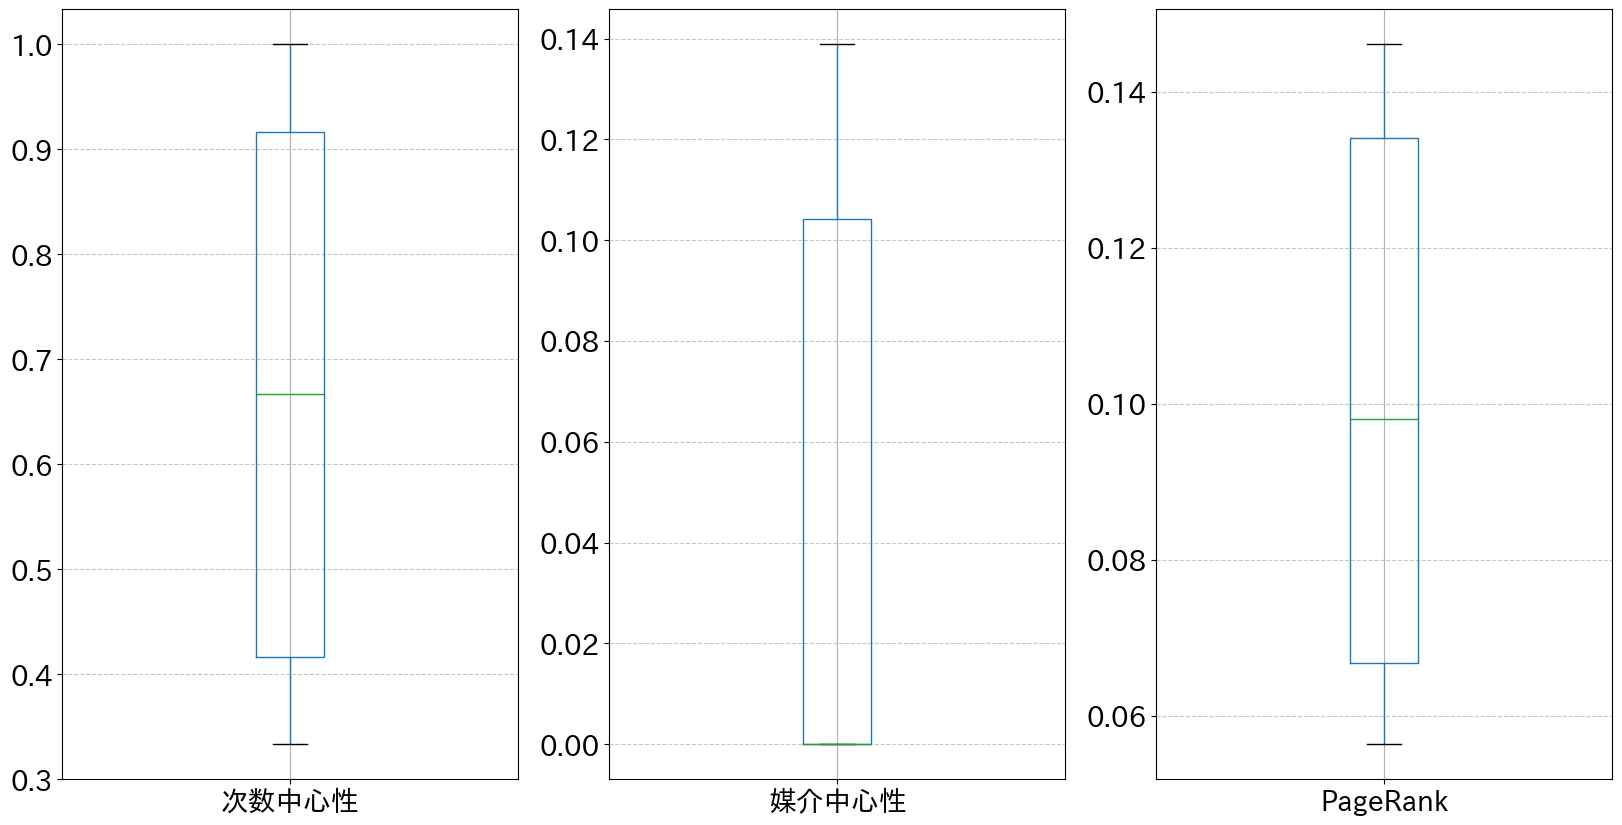

In [ ]:
# 箱ひげ図でcentrality_df_outを可視化(3つとも別の図)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
df_new_centrality.boxplot(column=["prediction_degree"])
# plt.title("生成グラフの次数中心性の箱ひげ図")
plt.xticks([1], ["次数中心性"], fontsize=20)
# plt.ylabel("次数中心性スコア")
plt.tick_params(axis='y', labelsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
df_new_centrality.boxplot(column=["prediction_betweenness"])
# plt.title("生成グラフの媒介中心性の箱ひげ図")
plt.xticks([1], ["媒介中心性"], fontsize=20)
# plt.ylabel("媒介中心性スコア")
plt.tick_params(axis='y', labelsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
df_new_centrality.boxplot(column=["prediction_pagerank"])
# plt.title("生成グラフのPageRankの箱ひげ図")
plt.xticks([1], ["PageRank"], fontsize=20)
# plt.ylabel("PageRankスコア")
plt.tick_params(axis='y', labelsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f"2025/jsme_data/boxplot_centrality_generated.png")
plt.show()

## GCNとの比較
- GCNによるリンク通知
- VGAEによるネットワーク生成との比較